In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

Different combinations of $(X, Y)$ to evaluate the approximation methods

In [3]:
X = np.random.exponential(size=40)[:, None]
#Y = np.random.chisquare(5, size=1000)[:, None]
#X = np.random.randn(40)[:, None]
Y = (np.random.randn(40)+20)[:, None]

Show quickly the distributions.

(array([13., 10.,  6.,  3.,  3.,  2.,  0.,  1.,  1.,  1.]),
 array([0.01915465, 0.5736941 , 1.12823355, 1.68277299, 2.23731244,
        2.79185189, 3.34639133, 3.90093078, 4.45547023, 5.01000967,
        5.56454912]),
 <a list of 10 Patch objects>)

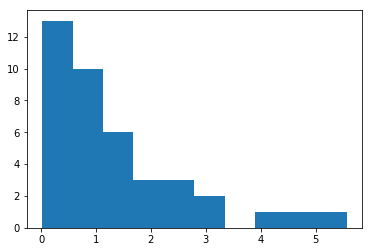

In [6]:
plt.hist(X, bins=10)

(array([1., 4., 2., 3., 6., 8., 9., 3., 2., 2.]),
 array([17.35542668, 17.84254364, 18.32966059, 18.81677755, 19.30389451,
        19.79101147, 20.27812842, 20.76524538, 21.25236234, 21.7394793 ,
        22.22659625]),
 <a list of 10 Patch objects>)

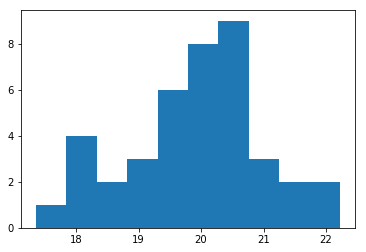

In [7]:
plt.hist(Y, bins=10)

### Auxiliary functions

In [8]:
def H(m):
    return np.identity(m) - (1/m) * (np.ones((m, m)))

# Gaussian kernel
def k(X, Y, sigma):
    sigma = median(X,Y)
    return metrics.pairwise.rbf_kernel(X.reshape(-1, 1), Y.reshape(-1, 1), gamma=1/(sigma**2))

# aggregate two samples
def agg_sample(X,Y):
    return np.array(list(X) + list(Y)).reshape(-1, 1)

# compute median
def median(X,Y):   
    distances = metrics.pairwise_distances(agg_sample(X,Y))    # distances in m x m matrix
    return np.median(distances)

# Biased MMD

First, we compute the biased MMD to have a measure how different the two distributions $P_X$ and $P_Y$ are in the RKHS.

In [9]:
# biased MMD estimator
def MMD_b(X,Y):
    Kx = metrics.pairwise.rbf_kernel(X)
    Ky = metrics.pairwise.rbf_kernel(Y)
    m = X.shape[0]
    
    return (1/m**2) * np.trace(Kx @ H(m) @ Ky @ H(m))

In [10]:
MMD_b(X, Y)

0.009933841780361573

# Unbiased MMD
Next, we compute the MMD with bias correction.

In [11]:
# unbiased MMD estimator
def MMD_u(X,Y):
    sigma = median(X,Y)
    m = X.shape[0]
    
    return np.sqrt( 1/(m*(m-1)) * (np.matrix(k(X,X,sigma)).sum() + np.matrix(k(Y,Y,sigma)).sum() - 2 * np.matrix(k(X,Y,sigma)).sum()))

In [12]:
MMD_u(X, Y)

0.9277121953676026

# HSIC with Gamma approximation

$\mathcal{H}_0 : P_{XY} = P_X P_Y$ is a complex distribution and must be approximated. Here, we approximate it by a Gamma distribution with parameters $\alpha$ (`al`) and $\beta$ (`beta`).

In [13]:
from scipy.stats import gamma

In [14]:
def HSIC_gamma(X,Y,alpha):
    
    # compute median
    sigma = median(X, Y)
    
    Kx = metrics.pairwise.rbf_kernel(X, gamma=1/(sigma**2))
    Ky = metrics.pairwise.rbf_kernel(Y, gamma=1/(sigma**2))
    
    m = X.shape[0]
    
    # c for centred Gram matrices
    Kx_c = H(m) @ Kx @ H(m)    
    Ky_c = H(m) @ Ky @ H(m)
    
    # test statistic
    stat = (1/m) * (Kx_c.T @ Ky_c).sum()
    
    mX = 1/(m*(m-1)) * (np.ones((m,1)).T @ Kx @ np.ones((m,1)))
    mY = 1/(m*(m-1)) * (np.ones((m,1)).T @ Ky @ np.ones((m,1)))
    
    varHSIC = (1/6 * (Kx_c.T @ Ky_c))**2
    varHSIC = 1/(m*(m-1)) * (np.sum(varHSIC) - np.trace(varHSIC))
    varHSIC = varHSIC * 72 * (m-4) * (m-5) / (m*(m-1)*(m-2)*(m-3))
    
    mHSIC = 1/m * (1 + mX * mY - mX - mY)
    
    # Gamma distribution parameters
    al = mHSIC**2 / varHSIC
    beta = m*varHSIC / mHSIC
    
    # 1-alpha threshold
    threshold = gamma.ppf(1-alpha, al, scale=beta)[0][0]
    
    if stat > threshold:
        print('H0 rejected')
    else:
        print('H0 accepted')
    
    return (stat, threshold)

In [15]:
# test level alpha = 0.05
print('p-value:', HSIC_gamma(X,Y,0.05)[0])
print('test threshold:', HSIC_gamma(X,Y,0.05)[1])

H0 accepted
p-value: -3.426078865054194e-18
H0 accepted
test threshold: 0.0


# dHSIC
$\mathcal{H}_0 : P_{\boldsymbol{X}} = P_{X_1} P_{X_2} P_{X_3} ... P_{X_d} $ must also be approximated.

In [23]:
# generate 50 random variables with m measurements each
X = np.random.randn(10000).reshape(50,-1)

In [24]:
# number of random variables d and measurements
d, m = X.shape

In [25]:
def dHSIC(X):
    K = {}

    for j in range(d):
        K[j] = metrics.pairwise.rbf_kernel(X[j].reshape(-1,1))    # m x m matrix

    term1 = np.ones((m,m))
    term2 = 1
    term3 = np.full((1,m), 2/m)

    for j in range(d):
        term1 = term1 @ K[j]
        term2 = 1/(m**2) * term2 * K[j].sum()
        term3 = 1/m * term3 * K[j].sum(axis=0)
    
    return 1/(m**2) * term1.sum() + term2 - term3.sum()

In [26]:
# joint independence between 50 random normal distributions with m measurements each
dHSIC(X)

6.749626757233165e+97